# Загружаем и распаковываем данные

In [1]:
# Загружаем и распаковываем данные# Импортируем библиотеки и указываем устройство, на котором будет производиться обучение модели!wget https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
!tar -xf imagewoof2-320.tgz

--2021-04-22 16:42:28--  https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.69.230
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.69.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328387740 (313M) [application/x-tar]
Saving to: ‘imagewoof2-320.tgz’

imagewoof2-320.tgz  100%[===================>] 313.17M  16.6MB/s    in 21s     

2021-04-22 16:42:50 (15.1 MB/s) - ‘imagewoof2-320.tgz’ saved [328387740/328387740]



# Импортируем библиотеки и указываем устройство, на котором будет производиться обучение модели

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from dataset import ImageWoofDataset
from training import train_model

IMAGE_PATH = './imagewoof2-320/'

torch.manual_seed(0)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

print("Device name", (torch.cuda.get_device_name() if (torch.cuda.is_available()) else "Cpu"))

Device name Tesla P100-PCIE-16GB


# В .csv-файле указаны пути к изображениям и соответствующие лейблы.

Будем работать с "noisy_labels_0", т.е. без перемешивания лейблов.

In [3]:
df = pd.read_csv('./imagewoof2-320/noisy_imagewoof.csv')
df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02115641/n02115641_3995.JPEG,n02115641,n02115641,n02115641,n02115641,n02115641,False
1,train/n02115641/n02115641_843.JPEG,n02115641,n02115641,n02105641,n02115641,n02088364,False
2,train/n02115641/n02115641_2953.JPEG,n02115641,n02115641,n02115641,n02111889,n02099601,False
3,train/n02115641/n02115641_6458.JPEG,n02115641,n02115641,n02115641,n02093754,n02115641,False
4,train/n02115641/n02115641_19414.JPEG,n02115641,n02115641,n02115641,n02115641,n02088364,False


# Распределение классов сбалансировано, за исключением одного

Для оценки работы модели подойдет метрика Accuracy

In [4]:
df[df['is_valid'] == False]['noisy_labels_0'].value_counts()

n02093754    949
n02099601    949
n02096294    943
n02087394    942
n02086240    941
n02115641    940
n02088364    932
n02105641    928
n02111889    921
n02089973    580
Name: noisy_labels_0, dtype: int64

In [5]:
label_dict = {label: i for i, label in enumerate(df['noisy_labels_0'].unique())}
inversed_label_dict = {value:key for key, value in label_dict.items()} 

In [6]:
train_images_paths = [IMAGE_PATH + path for path in df[df['is_valid'] == False]['path'].values]
val_images_paths = [IMAGE_PATH + path for path in df[df['is_valid'] == True]['path'].values]
train_labels = df[df['is_valid'] == False]['noisy_labels_0'].replace(label_dict).values
val_labels = df[df['is_valid'] == True]['noisy_labels_0'].replace(label_dict).values

# Также будем использовать аугментации для тренировочного датасета:

- Случайный кроп 224х224 (т.к. это стандартное разрешение для нашей модели)
- Случайное отражение по горизонтали и/или вертикали
- Случайное изменение яркости и контраста
- Случайное смещение по каналам цветов
- Нормализация по данным с ImageNet

In [7]:
train_transforms = A.Compose([
    A.RandomCrop(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transforms = A.Compose([
    A.RandomCrop(width=224, height=224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])


In [8]:
train_dataset = ImageWoofDataset(train_images_paths, train_labels, train_transforms)
val_dataset = ImageWoofDataset(val_images_paths, val_labels, val_transforms)

dataloaders = {}
dataloaders['train'] = DataLoader(train_dataset, batch_size=128, shuffle=True)
dataloaders['val'] = DataLoader(val_dataset, batch_size=100, shuffle=True)

# В качестве модели возьмем предобученную ResNet50 с заменой последнего слоя на десятиклассовый классификатор
***
Плюс т.к. ImageWoof - часть датасета ImageNet, а ResNet50 предобучена на ImageNet, обучение будет сходиться очень быстро

In [9]:
# В качестве модели возьмем предобученную ResNet50 с заменой последнего слоя на десятиклассовый классификатор
***
Плюс т.к. ImageWoof - часть датасета ImageNet, а ResNet50 предобучена на ImageNet, обучение будет сходиться очень быстроmodel = torchvision.models.resnet50(pretrained=True)

model.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model = model.to(device)

lr = 0.00001
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)
criterion = torch.nn.CrossEntropyLoss()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Обучаем модель

In [10]:
best_model, acc_history, loss_history = train_model(model, optimizer, dataloaders, criterion, num_epochs=15)

Epoch 0/14
----------
train Loss: 1.8009 Acc: 0.5108
val Loss: 1.0127 Acc: 0.8417
Epoch 1/14
----------
train Loss: 0.9189 Acc: 0.8107
val Loss: 0.5068 Acc: 0.8944
Epoch 2/14
----------
train Loss: 0.5559 Acc: 0.8658
val Loss: 0.3705 Acc: 0.9030
Epoch 3/14
----------
train Loss: 0.4470 Acc: 0.8790
val Loss: 0.3089 Acc: 0.9145
Epoch 4/14
----------
train Loss: 0.3688 Acc: 0.8951
val Loss: 0.2930 Acc: 0.9163
Epoch 5/14
----------
train Loss: 0.3264 Acc: 0.9060
val Loss: 0.2766 Acc: 0.9163
Epoch 6/14
----------
train Loss: 0.3132 Acc: 0.9046
val Loss: 0.2709 Acc: 0.9155
Epoch 7/14
----------
train Loss: 0.2773 Acc: 0.9160
val Loss: 0.2530 Acc: 0.9211
Epoch 8/14
----------
train Loss: 0.2658 Acc: 0.9168
val Loss: 0.2484 Acc: 0.9224
Epoch 9/14
----------
train Loss: 0.2517 Acc: 0.9242
val Loss: 0.2450 Acc: 0.9259
Epoch 10/14
----------
train Loss: 0.2477 Acc: 0.9260
val Loss: 0.2377 Acc: 0.9282
Epoch 11/14
----------
train Loss: 0.2260 Acc: 0.9334
val Loss: 0.2479 Acc: 0.9249
Epoch 12/14
--

# Посмотрим на графики обучения и валидации

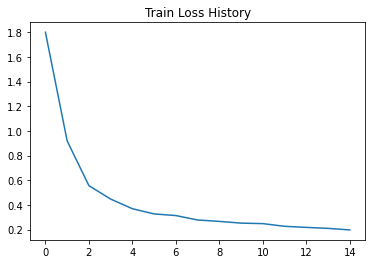

In [11]:
plt.plot(np.arange(0, len(loss_history)), loss_history)
plt.title('Train Loss History');

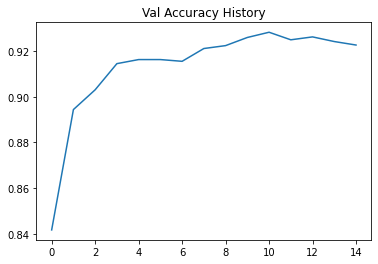

In [12]:
plt.plot(np.arange(0, len(acc_history)), acc_history)
plt.title('Val Accuracy History');

# Сохраним модель

In [13]:
torch.save(best_model.state_dict(), './model.pth')